In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import uproot 
import awkward as ak
from pathlib import Path

from typing import Dict, List 
import re
import pickle
from tqdm import tqdm
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [2]:
training_vars = ['jet_nTracks', 'jet_trackWidth', 'jet_trackC1']
training_weight = ['equal_weight']

This notebook explore MLP on 5 features. 

In [3]:
#FIXME No physics weights implemented in the MLP clf. 

In [4]:
sample_path = '../../samples/sample_all_jets.pkl'
sample = pd.read_pickle(sample_path)


In [5]:
sample[sample['jet_PartonTruthLabelID'] != -1]

,jet_pt,jet_eta,jet_nTracks,jet_trackWidth,jet_trackC1,jet_trackBDT,jet_PartonTruthLabelID,equal_weight,event_weight,flatpt_weight,is_forward,target
0,766.747925,1.298662,2.0,0.318292,0.215923,-0.192873,21.0,1.0,17.609434,2.703190e-05,1.0,1.0
0,680.507996,0.447689,24.0,0.064352,0.208339,0.066904,2.0,1.0,0.331535,2.858433e-07,0.0,0.0
1,619.839111,0.588775,34.0,0.115656,0.298206,0.232268,21.0,1.0,0.331535,1.655248e-07,1.0,1.0
2,721.692932,-0.716669,12.0,0.049718,0.220595,-0.169604,2.0,1.0,0.377624,3.935379e-07,0.0,0.0
3,697.332947,-1.042831,22.0,0.091199,0.278667,0.029374,21.0,1.0,0.377624,3.255802e-07,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3289,1457.898315,0.005210,34.0,0.115294,0.286379,0.114355,2.0,1.0,0.000004,6.099312e-10,0.0,0.0
3290,1995.521240,-0.060916,11.0,0.011609,0.114598,-0.515630,21.0,1.0,0.000005,1.795163e-08,0.0,1.0
3291,1609.661865,-0.132251,18.0,0.021626,0.172496,-0.195778,1.0,1.0,0.000005,1.934711e-09,1.0,0.0
3292,1849.435181,0.042168,27.0,0.038713,0.222048,0.089088,21.0,1.0,0.000004,5.221758e-09,0.0,1.0


In [6]:
X = sample.iloc[:, :-1]
y = sample.iloc[:, -1]

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

In [7]:
event_weight_idx = X.columns.get_loc('event_weight')
equal_weight_idx = X.columns.get_loc('equal_weight')
flatpt_weight_idx = X.columns.get_loc('flatpt_weight')

In [8]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  

scaler.fit(X_train[training_vars])  
X_train[training_vars] = scaler.transform(X_train[training_vars])  
X_test[training_vars] = scaler.transform(X_test[training_vars])  


In [9]:
clf = MLPClassifier(solver='adam', alpha=1e-5,
                    hidden_layer_sizes=(5, 2), random_state=42, verbose=True)
                    
clf.fit(X_train[training_vars], y_train)

Iteration 1, loss = 0.52434967
Iteration 2, loss = 0.52382001
Iteration 3, loss = 0.52381464
Iteration 4, loss = 0.52380538
Iteration 5, loss = 0.52380435
Iteration 6, loss = 0.52379892
Iteration 7, loss = 0.52379245
Iteration 8, loss = 0.52379127
Iteration 9, loss = 0.52378924
Iteration 10, loss = 0.52378760
Iteration 11, loss = 0.52378762
Iteration 12, loss = 0.52378219
Iteration 13, loss = 0.52378315
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=42,
              verbose=True)

In [10]:
y_test_decisions = clf.predict_proba(X_test[training_vars])[:,1]

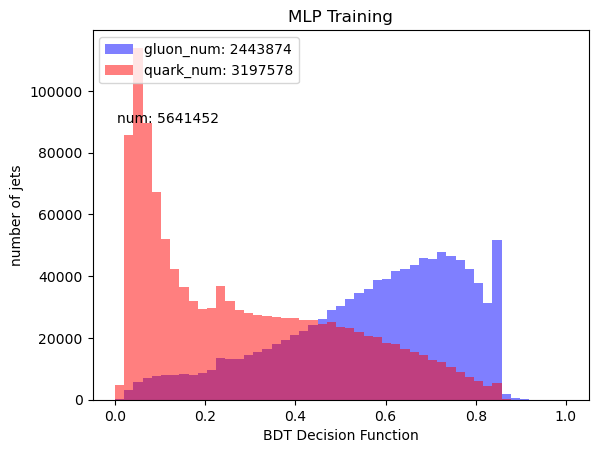

In [11]:
y_test_gluon_id = np.where(y_test==1)[0]
y_test_quark_id = np.where(y_test==0)[0]
bins_scores = np.linspace(0, 1, 50)
plt.hist(y_test_decisions[y_test_gluon_id], weights=X_test.iloc[y_test_gluon_id, event_weight_idx], bins= bins_scores, alpha=0.5, label='gluon'+f"_num: {len(y_test_gluon_id)}", color = 'blue') # add the weights! 
plt.hist(y_test_decisions[y_test_quark_id], weights=X_test.iloc[y_test_quark_id, event_weight_idx], bins= bins_scores, alpha=0.5, label='quark'+f"_num: {len(y_test_quark_id)}", color = 'red')
plt.legend(loc='upper left')
plt.text(0.05, 0.75, f"num: {len(X_test)}", transform=plt.gca().transAxes)
plt.xlabel("BDT Decision Function")
plt.ylabel("number of jets")
plt.title(r"MLP Training")
plt.savefig("MLP_Training.png", dpi=300)
plt.show()

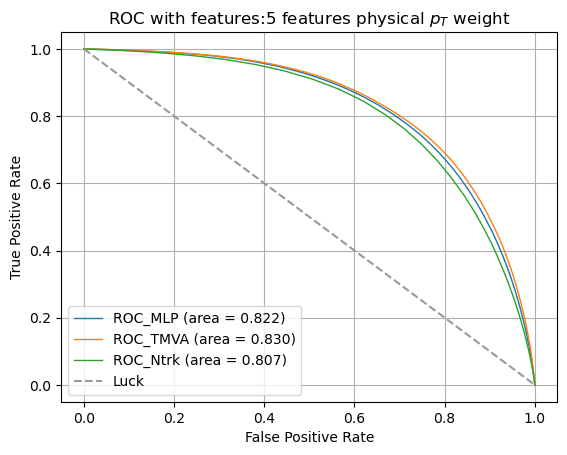

In [12]:
from sklearn.metrics import roc_curve, auc

def Draw_ROC_all(y, decisions, y_tmva, y_ntrk, X_weight, features):
    # Compute ROC curve and area under the curve
    fpr, tpr, thresholds = roc_curve(y, decisions, sample_weight = X_weight)
    fpr_tmva, tpr_tmva, thresholds_tmva = roc_curve(y, y_tmva, sample_weight = X_weight)
    fpr_ntrk, tpr_ntrk, thresholds_ntrk =  roc_curve(y, y_ntrk, sample_weight = X_weight)

    roc_auc = auc(fpr, tpr)
    roc_auc_tmva = auc(fpr_tmva, tpr_tmva)
    roc_auc_ntrk = auc(fpr_ntrk, tpr_ntrk)


    plt.plot(1-fpr, tpr, lw=1, label='ROC_MLP (area = %0.3f)'%(roc_auc))
    plt.plot(1-fpr_tmva, tpr_tmva, lw=1, label='ROC_TMVA (area = %0.3f)'%(roc_auc_tmva))
    plt.plot(1-fpr_ntrk, tpr_ntrk, lw=1, label='ROC_Ntrk (area = %0.3f)'%(roc_auc_ntrk))

    plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Luck')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC with features:{features}'+r" physical $p_{T}$ weight")
    plt.legend(loc="lower left")
    plt.grid()
    plt.savefig("ROC_physicalweight.png")
    plt.show()

Draw_ROC_all(y_test, y_test_decisions, y_tmva=X_test.iloc[:,X_test.columns.get_loc('jet_trackBDT')] , y_ntrk=X_test.iloc[:,X_test.columns.get_loc('jet_nTracks')], X_weight=X_test['event_weight'], features="5 features")


In [13]:
import pickle
filename = './MLP_classifier.model'
pickle.dump(clf, open(filename, 'wb'))

# Overtraining Validation

Text(0.5, 1.0, 'Overtraining test')

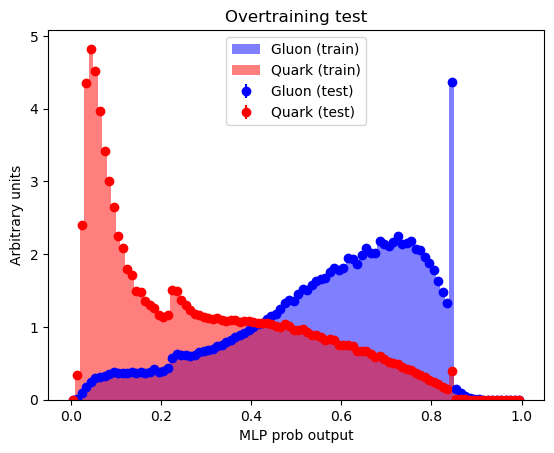

In [14]:
y_test_decisions = clf.predict_proba(X_test[training_vars])[:,1]
y_train_decisions = clf.predict_proba(X_train[training_vars])[:,1]


y_test_decisions_gluon = y_test_decisions[np.where(y_test==1)]
y_test_decisions_quark = y_test_decisions[np.where(y_test==0)]
y_train_decisions_gluon = y_train_decisions[np.where(y_train==1)]
y_train_decisions_quark = y_train_decisions[np.where(y_train==0)]
decisions = []
decisions.append(y_train_decisions_gluon)
decisions.append(y_train_decisions_quark)
decisions.append(y_test_decisions_gluon)
decisions.append(y_test_decisions_quark)


custom_bins = np.linspace(0, 1, 101)
custom_bin_width = (custom_bins[1] - custom_bins[0])
custom_bin_center = (custom_bins[:-1] + custom_bins[1:]) / 2

fig, ax = plt.subplots()
ax.hist(decisions[0], weights = X_train.iloc[np.where(y_train==1)[0], event_weight_idx],
            color='b', alpha=0.5, bins=custom_bins,
            histtype='stepfilled', density=True,
            label='Gluon (train)')
ax.hist(decisions[1], weights = X_train.iloc[np.where(y_train==0)[0], event_weight_idx],
            color='r', alpha=0.5, bins=custom_bins,
            histtype='stepfilled', density=True,
            label='Quark (train)')

hist, bins = np.histogram(decisions[2], weights=X_test.iloc[np.where(y_test==1)[0], event_weight_idx],
                            bins=custom_bins,  density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(custom_bin_center, hist, yerr=err, fmt='o', c='b', label='Gluon (test)')

hist, bins = np.histogram(decisions[3], weights=X_test.iloc[np.where(y_test==0)[0], event_weight_idx],
                            bins=custom_bins, density=True)
scale = len(decisions[2]) / sum(hist)
err = np.sqrt(hist * scale) / scale

plt.errorbar(custom_bin_center, hist, yerr=err, fmt='o', c='r', label='Quark (test)')
plt.xlabel("MLP prob output")
plt.ylabel("Arbitrary units")
plt.legend(loc='best')
plt.title("Overtraining test")


/global/cfs/cdirs/atlas/hrzhao/miniconda3/envs/ml/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


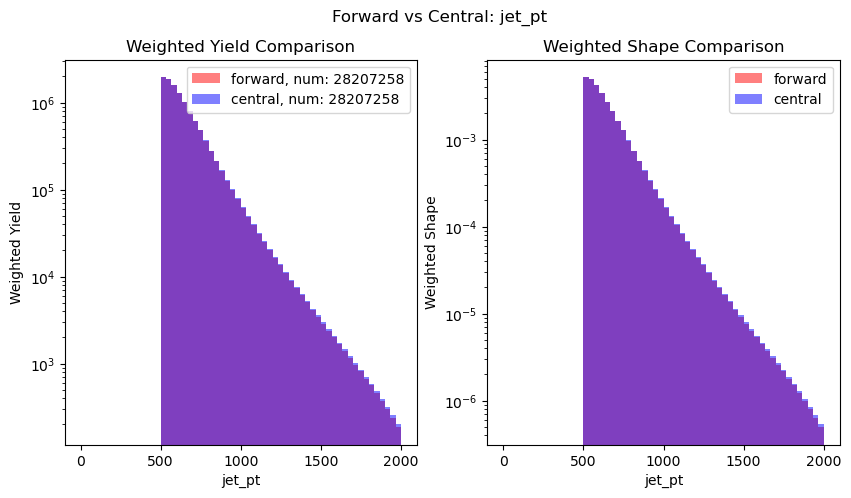

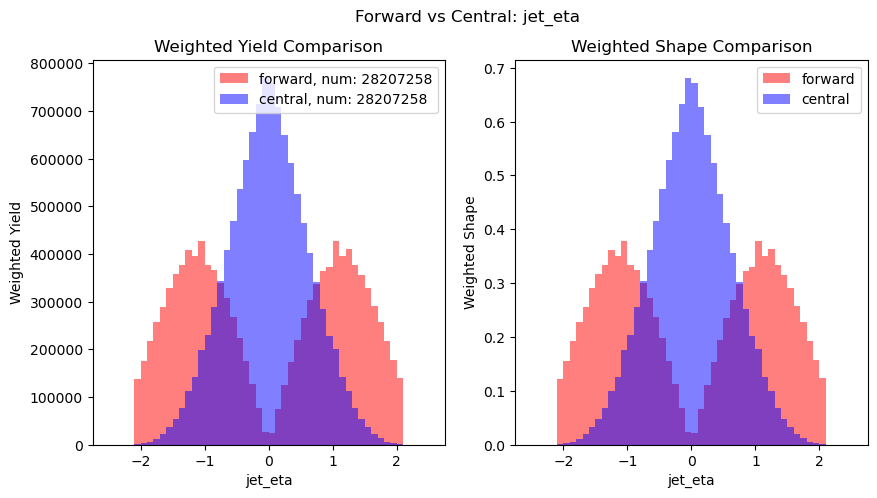

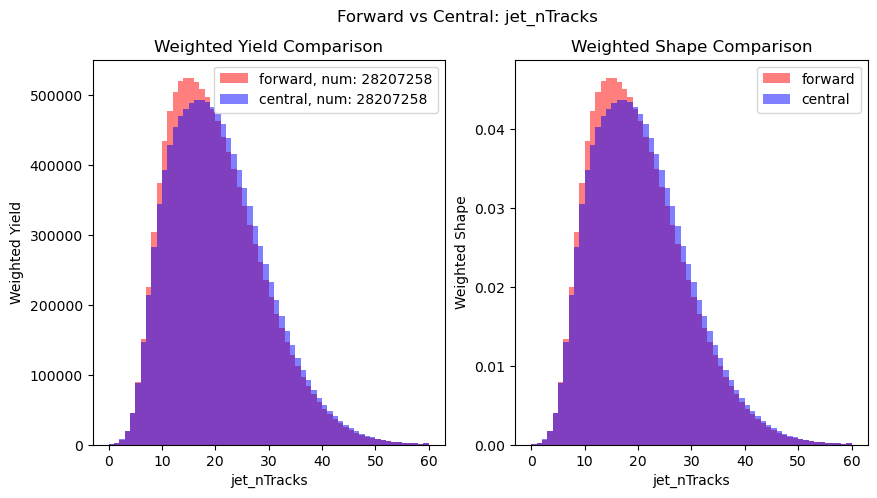

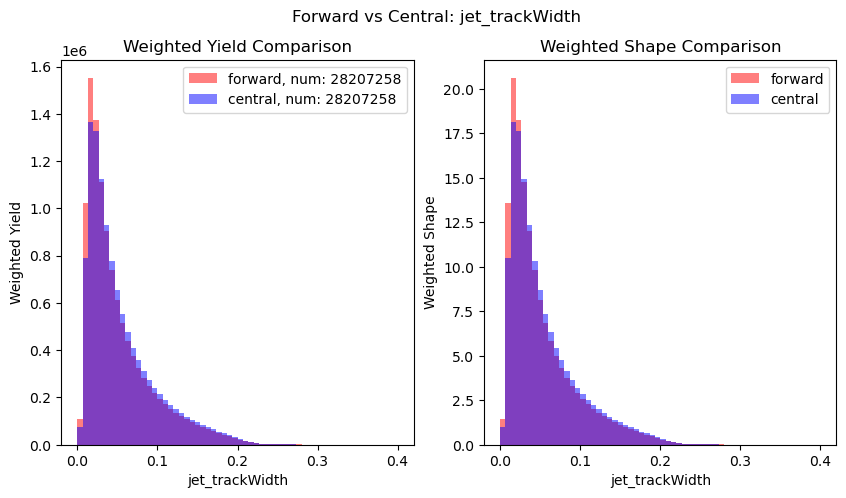

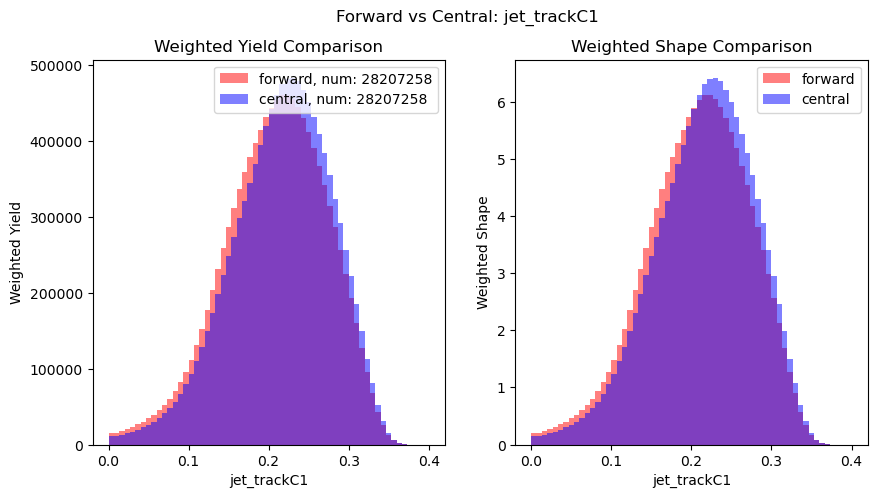

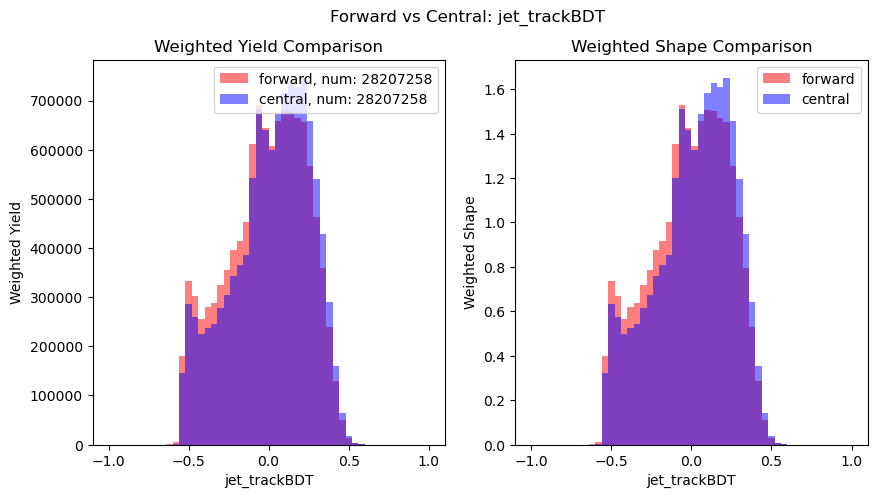

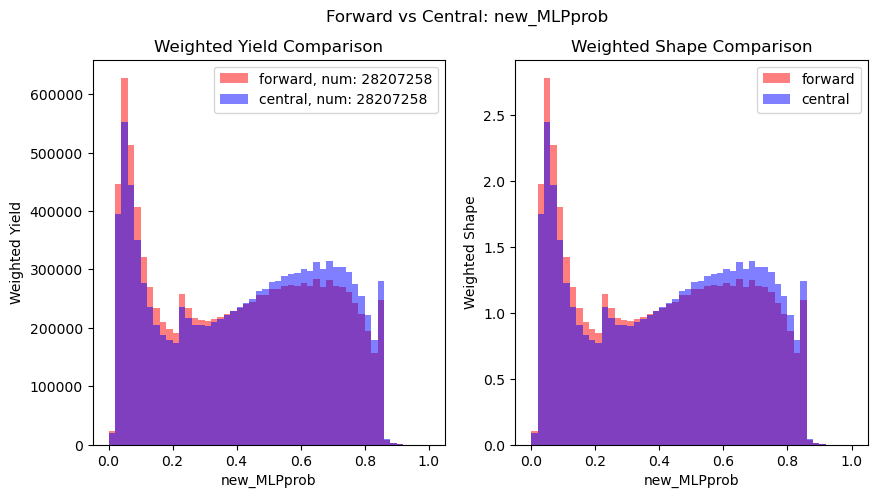

In [15]:
y_sample = clf.predict_proba(scaler.transform(sample[training_vars]))[:,1]
sample['new_MLPprob'] = y_sample

features = [*sample.columns[:6]] + ['new_MLPprob'] 
HistBins = {
    features[0] : np.linspace(0, 2000, 61), 
    features[1] : np.linspace(-2.5, 2.5, 51),
    features[2] : np.linspace(0, 60, 61),
    features[3] : np.linspace(0, 0.4, 61), 
    features[4] : np.linspace(0, 0.4, 61), 
    features[5] : np.linspace(-1.0, 1.0, 51), 
    features[6] : np.linspace(0.0, 1.0, 51),
}

sample_forward = sample[sample['is_forward']==1]
sample_central = sample[sample['is_forward']==0]

for feature_name in features:
    custom_bins = HistBins[feature_name]
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
    ax0.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], label = f'forward, num: {len(sample_forward)}', color='red', alpha = 0.5)
    ax0.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], label = f'central, num: {len(sample_central)}', color='blue', alpha = 0.5)
    ax0.legend()
    ax0.set_xlabel(feature_name)
    ax0.set_ylabel(f"Weighted Yield")
    ax0.set_title(f"Weighted Yield Comparison")

    if feature_name == 'jet_pt':
        ax0.set_yscale('log')

    ax1.hist(sample_forward[feature_name], bins = custom_bins, weights = sample_forward['event_weight'], label = 'forward', color='red', alpha = 0.5, density=True)
    ax1.hist(sample_central[feature_name], bins = custom_bins, weights = sample_central['event_weight'], label = 'central', color='blue', alpha = 0.5, density=True)
    ax1.legend()
    ax1.set_xlabel(feature_name)
    ax1.set_ylabel(f"Weighted Shape")
    ax1.set_title(f"Weighted Shape Comparison")
    if feature_name == 'jet_pt':
        ax1.set_yscale('log')
    fig.suptitle(f"Forward vs Central: {feature_name}")

    plt.plot()
    

In [16]:
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Text(0.5, 0.98, 'new_MLPprob')

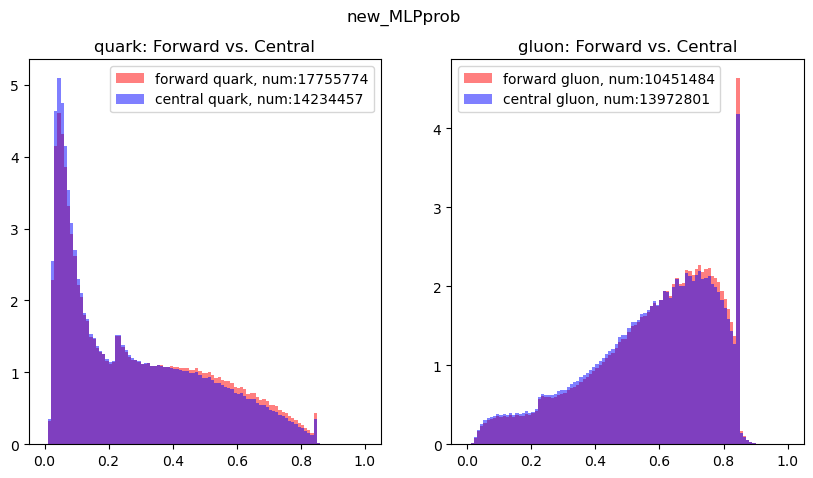

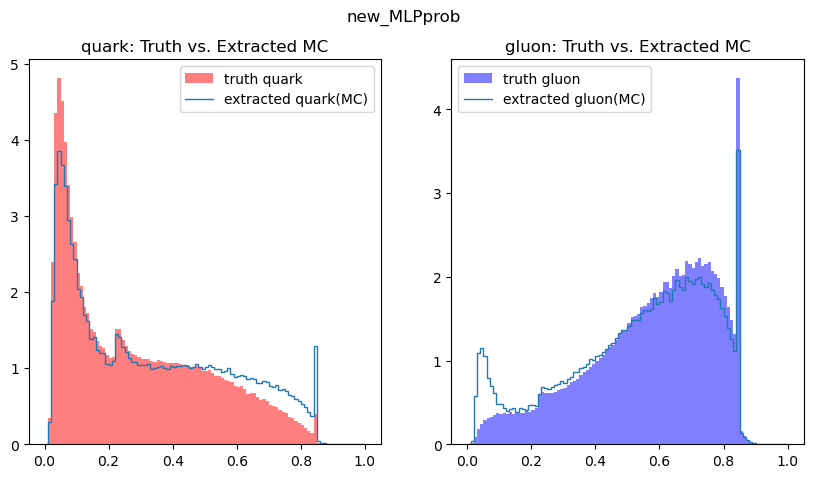

In [17]:

forward_quark = sample[(sample['is_forward']==1) &(sample['target']==0)]
forward_gluon = sample[(sample['is_forward']==1) &(sample['target']==1)]
central_quark = sample[(sample['is_forward']==0) &(sample['target']==0)]
central_gluon = sample[(sample['is_forward']==0) &(sample['target']==1)]
forward = sample[(sample['is_forward']==1)]
central = sample[(sample['is_forward']==0)]
quark = sample[sample['target']==0]
gluon = sample[sample['target']==1]

newbdt_bins = np.linspace(0.0, 1.0, 101)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
feature = 'new_MLPprob'
ax[0].hist(forward_quark[feature], bins=newbdt_bins, weights=forward_quark['event_weight'], 
          label=f'forward quark, num:{len(forward_quark)}', color='red', alpha = 0.5, density=True)
ax[0].hist(central_quark[feature], bins=newbdt_bins, weights=central_quark['event_weight'], 
          label=f'central quark, num:{len(central_quark)}', color='blue', alpha = 0.5, density=True)
ax[0].legend()
ax[0].set_title('quark: Forward vs. Central')

ax[1].hist(forward_gluon[feature], bins=newbdt_bins, weights=forward_gluon['event_weight'],
          label=f'forward gluon, num:{len(forward_gluon)}', color='red', alpha = 0.5, density=True)
ax[1].hist(central_gluon[feature], bins=newbdt_bins, weights=central_gluon['event_weight'], 
          label=f'central gluon, num:{len(central_gluon)}', color='blue', alpha = 0.5, density=True)
ax[1].set_title('gluon: Forward vs. Central')
ax[1].legend()
fig.suptitle(feature)




n_forward_quark = len(forward_quark)
n_central_quark = len(central_quark)
n_forward = len(forward)
n_central = len(central)

frac_forward_quark = n_forward_quark / n_forward
frac_central_quark = n_central_quark / n_central

frac_forward_gluon = 1 - frac_forward_quark
frac_central_gluon = 1 - frac_central_quark

f = np.array([[frac_forward_quark,  frac_forward_gluon], [frac_central_quark, frac_central_gluon]])
f_inv = np.linalg.inv(f)


# Do a simple extraction test
# MC closure 
feature = 'new_MLPprob'
newbdt_bins = np.linspace(0.0, 1.0, 101)
hist_forward, _ = np.histogram(forward[feature], newbdt_bins, weights=forward['event_weight'], density = True)
hist_central, _ = np.histogram(central[feature], newbdt_bins, weights=central['event_weight'], density = True)


extract_p_Quark = f_inv[0][0] * hist_forward + f_inv[0][1]* hist_central 
extract_p_Gluon = f_inv[1][0] * hist_forward + f_inv[1][1]* hist_central 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax[0].hist(quark[feature], bins=newbdt_bins, weights=quark['event_weight'], 
          label=f'truth quark', color='red', alpha = 0.5, density=True)
ax[0].stairs(values=extract_p_Quark, edges=newbdt_bins, label=f'extracted quark(MC)')
ax[0].legend()
ax[0].set_title('quark: Truth vs. Extracted MC')

ax[1].hist(gluon[feature], bins=newbdt_bins, weights=gluon['event_weight'], 
          label=f'truth gluon', color='blue', alpha = 0.5, density=True)
ax[1].stairs(values=extract_p_Gluon, edges=newbdt_bins, label=f'extracted gluon(MC)')
ax[1].legend()
ax[1].set_title('gluon: Truth vs. Extracted MC')

fig.suptitle(feature)
